In [ ]:
O ElasticNet foi usado e constatado que o modelo está tendendo para o Ridge (o l1_ratio está próximo de 0.
Para reduzir o tempo de execução do modelo (em relação ao ElasticNet), o Ridge será aplicado.

ElasticNet was used and it was found that the model is tending towards Ridge (l1_ratio is close to 0).
To reduce the model execution time (compared to ElasticNet), Ridge will be applied.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from joblib import dump

from src.config import DADOS_LIMPOS, MODELO_FINAL
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50.0,1120.0,283.0,697.0,264.0,2.1250,140000.0,NEAR BAY,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50.0,2239.0,455.0,990.0,419.0,1.9911,158700.0,NEAR BAY,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 17564 non-null  float64
 1   latitude                  17564 non-null  float64
 2   housing_median_age        17564 non-null  float64
 3   total_rooms               17564 non-null  float64
 4   total_bedrooms            17564 non-null  float64
 5   population                17564 non-null  float64
 6   households                17564 non-null  float64
 7   median_income             17564 non-null  float64
 8   median_house_value        17564 non-null  float64
 9   ocean_proximity           17564 non-null  object 
 10  rooms_per_household       17564 non-null  float64
 11  population_per_household  17564 non-null  float64
 12  bedrooms_per_room         17564 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.7+ MB


In [4]:
#na Análise Exploratória foi constatado a relação com localização geográfica
# In the Exploratory Analysis, a relationship with geographical location was found
kmeans = KMeans(n_clusters=5)
#na Análise Exploratória foi constatado a relação com localização geográfica
# In the Exploratory Analysis, a relationship with geographical location was found
df['median_income_cat'] = kmeans.fit_predict(df[['longitude', 'latitude', 'median_income']])



In [7]:
coluna_target=['median_house_value']

coluna_one_hot_encoder=['ocean_proximity','median_income_cat']


In [9]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder)

colunas_robust_scaler 

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [10]:
pipeline_robust= Pipeline(steps=[
    ('robust_scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))
])    

preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('robust_scaler_poly', pipeline_robust, colunas_robust_scaler),
    ],
)



In [11]:
X=df.drop(columns=coluna_target)
y=df[coluna_target]

In [12]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room,median_income_cat
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY,6.984127,2.555556,0.146591,4
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY,6.238137,2.109842,0.155797,4
2,-122.260002,37.840000,42.0,2555.0,665.0,1206.0,595.0,2.0804,NEAR BAY,4.294117,2.026891,0.260274,1
3,-122.260002,37.849998,50.0,1120.0,283.0,697.0,264.0,2.1250,NEAR BAY,4.242424,2.640152,0.252679,1
4,-122.260002,37.840000,50.0,2239.0,455.0,990.0,419.0,1.9911,NEAR BAY,5.343676,2.362768,0.203216,1


In [13]:
y.head()

,median_house_value
0,452600.0
1,358500.0
2,226700.0
3,140000.0
4,158700.0


In [14]:
param_grid = {
    #avaliar se relações não lineares melhoram o modelo. 
    #assess whether non-linear relationships improve the model.
    'regressor__preprocessor__robust_scaler_poly__poly__degree':[1, 2, 3],
    #testar valores alpha (maior ou menor regulazição dos dados)
    #test alpha values ​​(greater or lesser regularization of data)
    'regressor__reg__alpha': [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 25.0],
    
}

In [15]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
    param_grid=param_grid,
)
grid_search    

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity',
                                                                                                               'median_income_cat']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               RobustScaler()),
                                                                                                                              ('poly',
                                                                                                                               PolynomialFeature...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   25.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [16]:
grid_search.fit( X,y)   

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity',
                                                                                                               'median_income_cat']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               RobustScaler()),
                                                                                                                              ('poly',
                                                                                                                               PolynomialFeature...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   25.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [17]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 10.0}

In [18]:
grid_search.best_score_

-50424.971622922974

In [19]:
coefs=dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

In [20]:
coefs

,coeficiente
robust_scaler_poly__longitude,-1.037620
robust_scaler_poly__latitude,-0.974046
one_hot__ocean_proximity_INLAND,-0.471120
robust_scaler_poly__latitude longitude population_per_household,-0.422009
robust_scaler_poly__bedrooms_per_room^2 total_rooms,-0.332715
...,...
robust_scaler_poly__housing_median_age median_income,0.247063
robust_scaler_poly__latitude^2 longitude,0.250534
robust_scaler_poly__latitude median_income population_per_household,0.257832
robust_scaler_poly__bedrooms_per_room,0.332676


In [21]:
coefs[coefs['coeficiente']==0]

,coeficiente


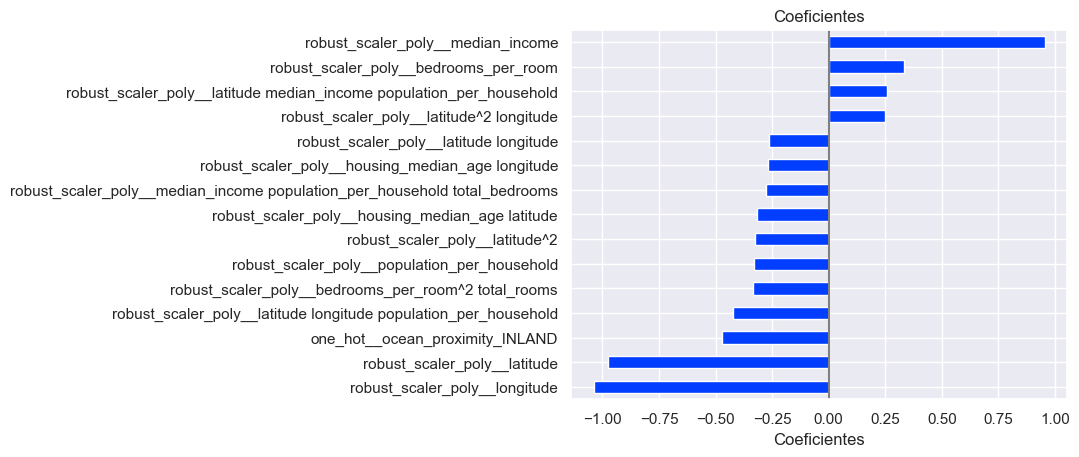

In [22]:
plot_coeficientes(coefs[~coefs['coeficiente'].between(-0.25,0.25)])

In [23]:
target_transformer = PowerTransformer()

regressors = {
    'DummyRegressor':{
        'preprocessor':None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinnearRegression':{
        'preprocessor':preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
  'LinnearRegression_target':{
        'preprocessor':preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': QuantileTransformer(output_distribution='normal'),
    },
    'Ridge_grid_search':{
        'preprocessor':grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer':grid_search.best_estimator_.transformer,
    },
}    
resultados= {
    nome_modelo: treinar_e_validar_modelo_regressao(X,y,**regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.006352,0.007593,-0.000081,-77516.042766,-96239.705692,0.013945
1,DummyRegressor,0.004133,0.006273,-0.000146,-75787.787194,-95217.629397,0.010406
2,DummyRegressor,0.005892,0.006924,-0.001737,-76753.598961,-96253.253947,0.012816
3,DummyRegressor,0.0,0.012332,-0.000101,-76837.804811,-95983.885799,0.012332
4,DummyRegressor,0.005187,0.008434,-0.000114,-76617.245449,-96182.764729,0.013621
5,LinnearRegression,0.062991,0.017491,0.682945,-39677.924415,-54188.14491,0.080482
6,LinnearRegression,0.053686,0.02261,0.671086,-40136.746358,-54604.329137,0.076297
7,LinnearRegression,0.070522,0.021832,0.649764,-42089.922017,-56913.99032,0.092354
8,LinnearRegression,0.070021,0.023155,0.671842,-40660.402589,-54981.631194,0.093176
9,LinnearRegression,0.066843,0.019845,0.67064,-40596.487796,-55196.015789,0.086688


In [24]:
df_resultados.groupby('model').mean().sort_values(by='test_neg_root_mean_squared_error')	


,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004313,0.008311,-0.000436,-76702.495836,-95975.447913,0.012624
LinnearRegression,0.064813,0.020987,0.669255,-40632.296635,-55176.82227,0.085799
LinnearRegression_target,0.080434,0.022016,0.678709,-38585.872915,-54378.180376,0.102449
Ridge_grid_search,0.25346,0.045518,0.723647,-35313.135459,-50424.134444,0.298978


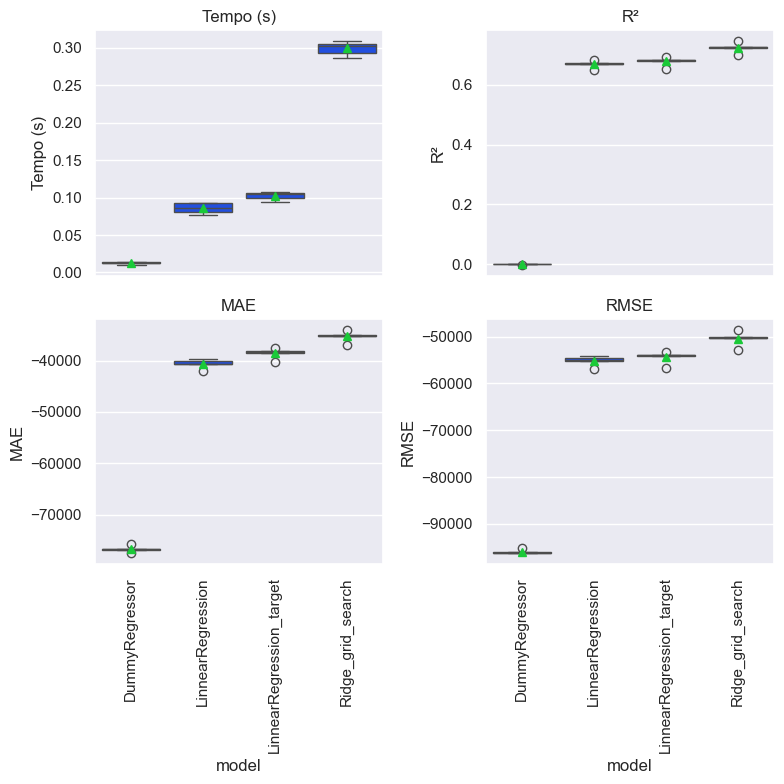

In [25]:
plot_comparar_metricas_modelos(df_resultados)

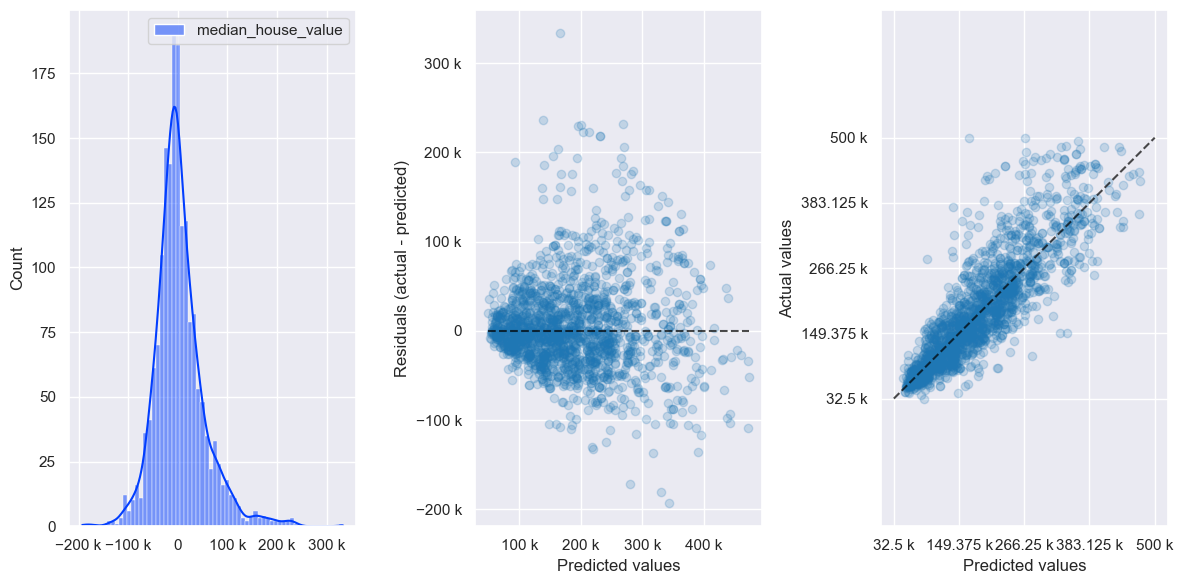

In [26]:
plot_residuos_estimador(grid_search.best_estimator_, X,y, fracao_amostra=0.1, eng_formatter=True)


In [27]:
dump(grid_search.best_estimator_,MODELO_FINAL)

['D:\\ciencias_dados\\python_pratica\\hashtag\\ciencias_dados\\machine_learning\\modelos_lineares\\regressao\\projeto\\modelos\\ridge_polyfeat_target_quantile.joblib']

Conclusão:

O modelo Ridge com os melhores hiperparâmetros encontrados pelo GridSearchCV teve o melhor desempenho, com R² de 0.723 e RMSE de -50453.18.

O uso de polinômios de grau 3 (degree=3) e uma regularização forte (alpha=20.0) permitiu que o modelo capturasse relações não lineares nos dados sem overfitting.

Apesar de ser o modelo mais lento (0.24843 segundos), ele ofereceu o melhor equilíbrio entre viés e variância.

Conclusion:

The Ridge model with the best hyperparameters found by GridSearchCV performed best, with R² of 0.723 and RMSE of -50453.18.

The use of degree 3 polynomials (degree=3) and strong regularization (alpha=20.0) allowed the model to capture non-linear relationships in the data without overfitting.

Despite being the slowest model (0.24843 seconds), it offered the best balance between bias and variance.
